## Climate Adaptation Digital Twin: heating degrees days in Germany

In this tutorial we will use the [`https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr`](https://earthdatahub.destine.eu/collections/d1-climate-dt-ScenarioMIP-SSP3-7.0-IFS-NEMO/datasets/0001-high-sfc) dataset to compute heating degrees days in Germany according to the Climate Adaptation Digital Twin. 

Access to this dataset is restricted to authorized user only via the the Data Cache Management service. You need to instruct your tools (e.g. Xarray, Zarr...) to use the Data Cache Management service.
First, make sure you have an account on the [Destination Earth platform](https://platform.destine.eu). Then, with your Destination Earth credentials at hand, run:

%%capture cap
%run ../cacheb/cacheb-authentication.py

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write("\n".join(cap.stdout.split('\n')[1:]))

⚠ **NOTE**: the generated password is valid for a limited period of time, and needs to be regenerated and reconfigured periodically by running the cells above.

#### 1. Access and preview the data with Xarray

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically when you access a Zarr dataset:


In [246]:
import xarray as xr

url = "https://cacheb.dcms.destine.eu/d1-climate-dt/ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr"

ds = xr.open_dataset(
    url, 
    chunks={}, 
    engine="zarr", 
    storage_options={"client_kwargs": {"trust_env": True}}
)
ds

<xarray.Dataset> Size: 188TB
Dimensions:            (time: 175320, latitude: 4096, longitude: 8193)
Coordinates:
  * latitude           (latitude) float64 33kB -90.0 -89.96 ... 89.96 90.0
  * longitude          (longitude) float64 66kB -180.0 -180.0 ... 180.0 180.0
    step               timedelta64[ns] 8B ...
    surface            float64 8B ...
  * time               (time) datetime64[ns] 1MB 2020-01-01 ... 2039-12-31T23...
Data variables:
    d2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    heightAboveGround  float64 8B ...
    sd                 (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    ssr                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    str                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    t2m                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    tprate             (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    u10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
    v10                (time, latitude, longitude) float32 24TB dask.array<chunksize=(48, 512, 512), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-06-06T16:50 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

⚠ At this point, no data has been downloaded yet, nor loaded in memory.

In [248]:
germany = {'latitude': slice(47, 55), 'longitude': slice(5, 16)}

t2m = ds.t2m
t2m = ds.t2m.astype("float32") - 273.15
t2m.attrs["units"] = "C"

t2m_germany = t2m.sel(**germany)

In [249]:
t2m_germany_QS_DEC = t2m_germany.resample(time='QS-DEC').mean(dim="time")
t2m_germany_winters= t2m_germany_QS_DEC[t2m_germany_QS_DEC.time.dt.month.isin([12])]
t2m_germany_winters

<xarray.DataArray 't2m' (time: 21, latitude: 182, longitude: 251)> Size: 4MB
dask.array<getitem, shape=(21, 182, 251), dtype=float32, chunksize=(1, 182, 251), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 1kB 47.01 47.05 47.1 ... 54.88 54.92 54.97
  * longitude  (longitude) float64 2kB 5.01 5.054 5.098 ... 15.91 15.95 16.0
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 168B 2019-12-01 2020-12-01 ... 2039-12-01
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           C

In [250]:
%%time

t2m_germany_winters.compute();

CPU times: user 2min 3s, sys: 1min 11s, total: 3min 14s
Wall time: 54.9 s


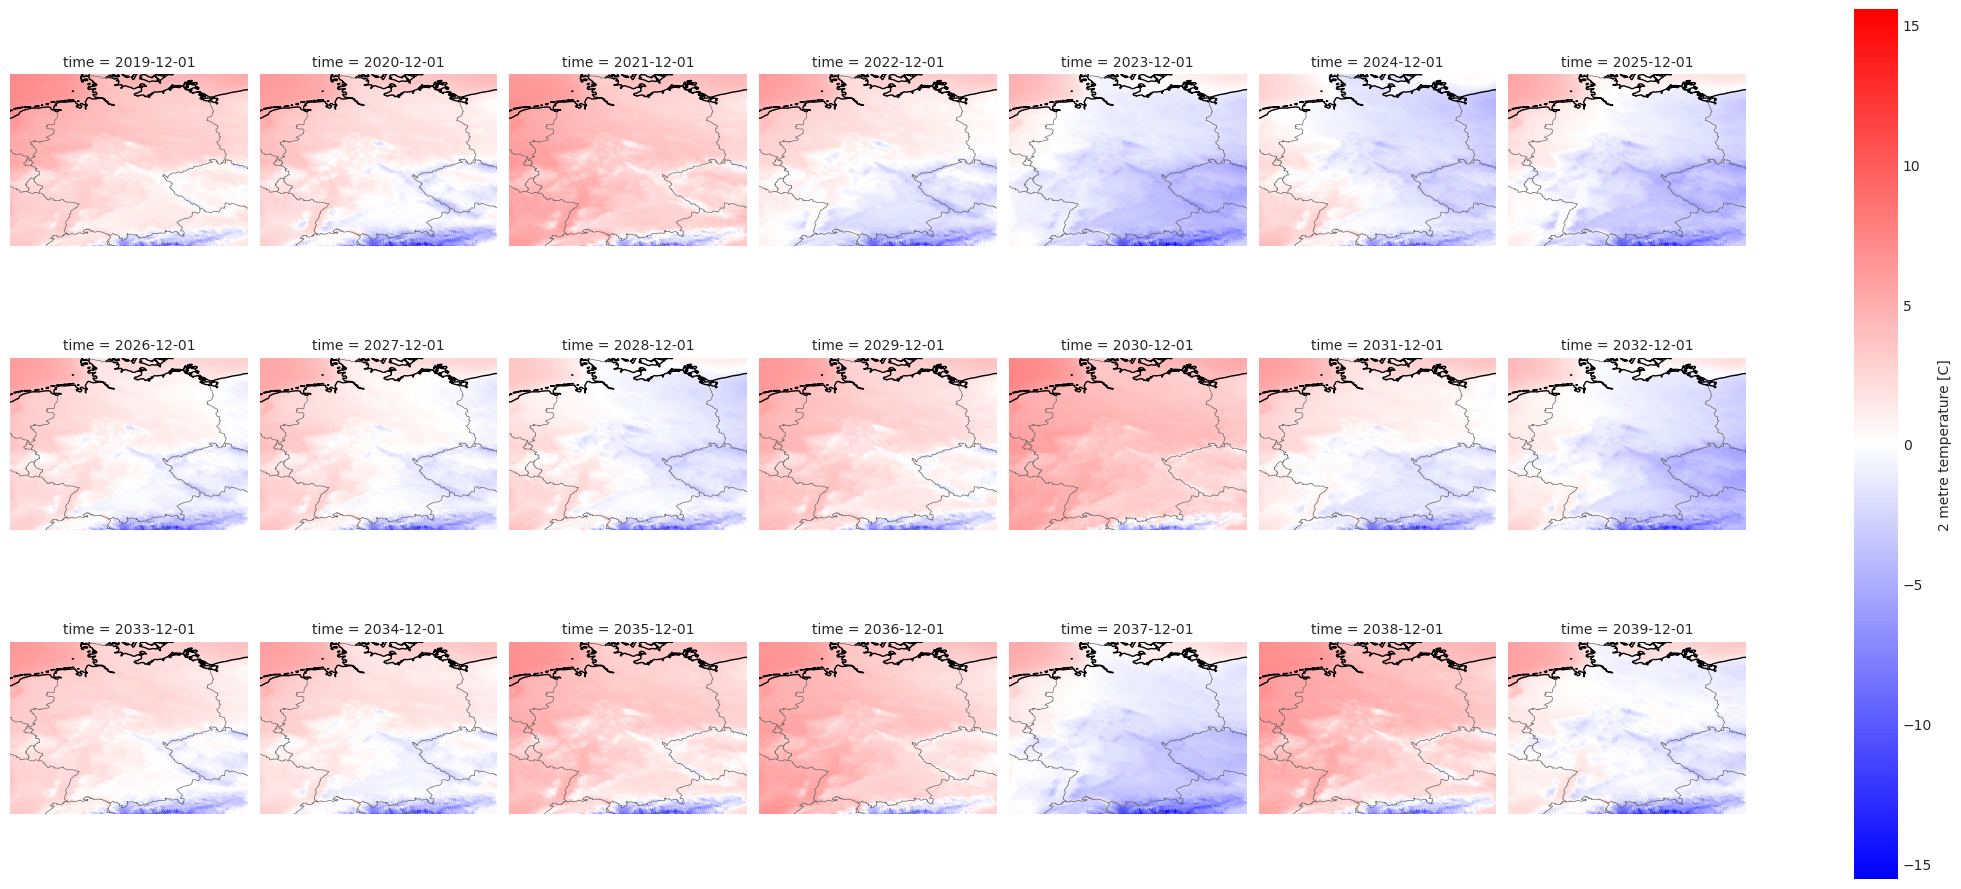

In [251]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy import feature

p = t2m_germany_winters.plot(
    x="longitude", 
    y="latitude", 
    col="time", 
    col_wrap=t2m_germany_winters.sizes['time']//3,
    subplot_kws={'projection': ccrs.PlateCarree()},
    cmap = "bwr"
) 
for ax in p.axs.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS, linewidth=0.5, edgecolor='dimgrey')

### Heating Degrees Days

In [257]:
darmstadt = {"latitude": 49.878708, "longitude": 8.646927}
base_temperature = 15 #[°C]

t2m_darmstadt = t2m.sel(**Darmstadt, method="nearest")

In [258]:
%%time
t2m_darmstadt_daily_mean = t2m_darmstadt.resample(time='1D').mean(dim='time')
diff = (base_temperature - t2m_darmstadt_daily_mean)
hdd = diff.where(diff > 0).groupby("time.year").sum()

hdd.compute()

CPU times: user 6min 19s, sys: 4min 45s, total: 11min 5s
Wall time: 3min 22s


<xarray.DataArray 't2m' (year: 20)> Size: 80B
array([1978.1611, 2007.0818, 2197.3755, 2384.5713, 2453.4175, 2241.8225,
       2182.4236, 2155.0173, 2206.7715, 2094.9048, 2129.8838, 2137.711 ,
       2223.3882, 2281.0256, 2203.4006, 1992.7379, 2050.3528, 1808.1298,
       2258.0378, 1972.7424], dtype=float32)
Coordinates:
    latitude   float64 8B 49.87
    longitude  float64 8B 8.657
    step       timedelta64[ns] 8B 00:00:00
    surface    float64 8B 0.0
  * year       (year) int64 160B 2020 2021 2022 2023 ... 2036 2037 2038 2039
Attributes: (12/19)
    GRIB_NV:                         0
    GRIB_cfName:                     air_temperature
    GRIB_cfVarName:                  t2m
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  150
    GRIB_gridType:                   healpix
    ...                              ...
    GRIB_typeOfLevel:                heightAboveGround
    GRIB_units:                      K
    last_restart_dim_updated:        175320
    long_name:                       2 metre temperature
    standard_name:                   air_temperature
    units:                           C

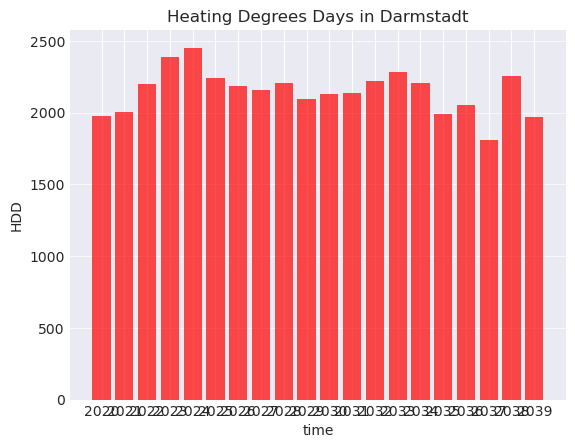

In [259]:
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-darkgrid")
plt.bar(hdd.year, hdd.values, color='#ff0000', alpha=0.7) #width=4
plt.xlabel('time')
plt.ylabel('HDD')
plt.grid(axis='y', alpha=0.75)
plt.title('Heating Degrees Days in Darmstadt')
plt.xticks(hdd.year[::3]);

### Inpact on population:

Load the population dataset from Earth Data Hub:

In [ ]:
population = xr.open_dataset(
    "https://hedp-data.bopen.eu/public/derived-GPWv4-Histsoc/demographics-hybrid-1950-2020-15-min-v0",
    chunks={},
    engine="zarr",
)
population = population.assign_coords(longitude=(((population.longitude + 180) % 360) - 180))
population = population.roll(longitude=int(len(population.longitude) / 2), roll_coords=True)
population = population.reindex(latitude=population.latitude[::-1])

population.demographic_totals.isel(year=-1).sum("age_band_lower_bound", skipna=False).plot(vmax=50_000, cmap="YlGnBu_r")

Filter Germany

In [ ]:
import display
data = population.demographic_totals.sel(**germany).isel(year=-1).sum("age_band_lower_bound", skipna=False)
display.map(data, vmax=50_000, projection=ccrs.PlateCarree(), cmap="YlGnBu_r")

In [ ]:
population_darmstadt=population.sel(year=2020, **darmstadt, method="nearest").demographic_totals.sum("age_band_lower_bound")
population_darmstadt.values

In [ ]:
import math
def estimate_download_cost(origin, selection):    
    base_chunk_shape = {key:value[0] for key,value in origin.chunksizes.items()}
    print('base_chunk_shape: ',base_chunk_shape)
    
    needed_chunks_count_by_dim = {key:len(value) for key,value in selection.chunksizes.items()}
    for key in origin.chunksizes.keys():
        if key not in needed_chunks_count_by_dim.keys():
            needed_chunks_count_by_dim.update({key:1})
    print('needed_chunks_count_by_dim: ',needed_chunks_count_by_dim)
    print("total number of needed chunks: ", math.prod([val for val in needed_chunks_count_by_dim.values()]))
    
    estimated_download_shape = {key: base_chunk_shape[key]*needed_chunks_count_by_dim[key] for key in origin.chunksizes}
    print('estimated_download_shape: ', estimated_download_shape) 
    
    estimated_download_fields = math.prod(estimated_download_shape[key] for key in estimated_download_shape)
    print('estimated_download_fields : ', estimated_download_fields)

    estimated_dowload_size = int(str(selection.dtype)[-2:])//8*estimated_download_fields
    print(f'estimated_dowload_size: "{round(estimated_dowload_size/1024**3, 3):,} GiB"')

    #print({key: f"{round(value/1024**4, 3):,} GiB" for key, value in memory_size.items()})

In [ ]:
#estimate_download_cost(t2m, t2m_germany[t2m_germany.time.dt.month.isin([12,1,2])])

In [ ]:
#estimate_download_cost(t2m, t2m_darmstadt)

In [ ]:
print(plt.style.available)